# Advanced peakbagging

In the **Quickstart** section, I explained how to quickly handle seismic data and perform peakbagging over it. However, when dealing with individual mode parameters, you will sometimes need more flexibility on the fit you want to perform.
The goal of this tutorial is to show you how to fit the background in your data and then perform an advanced fit on individual parameters thanks to the *a2z* input format.

In [1]:
import numpy as np
import apollinaire as apn
from os import path
import importlib.resources
import apollinaire.timeseries as timeseries
from apollinaire.peakbagging import (peakbagging, 
                                     perform_mle_background, 
                                     explore_distribution_background,
                                     read_a2z)

In [2]:
f = importlib.resources.path (timeseries, 'kplr006603624_52_COR_filt_inp.fits')
with f as filename :
    hdu = fits.open (filename) [0]
data = np.array (hdu.data)
t = data[:,0]
v = data[:,1]
dt = np.median (t[1:] - t[:-1]) * 86400
freq, psd = apn.psd.series_to_psd (v, dt=dt, correct_dc=True)
freq = freq*1e6
psd = psd*1e-6

## Dealing with the background

The ``perfom_mle_background`` allows you to obtain a first fit of the background in your data through maximum likelihood estimation:

dnu computed with scaling law: 135.0 muHz
numax computed with scaling law: 3050.0 muHz
Background model likelihood minimisation:
Optimization terminated successfully.


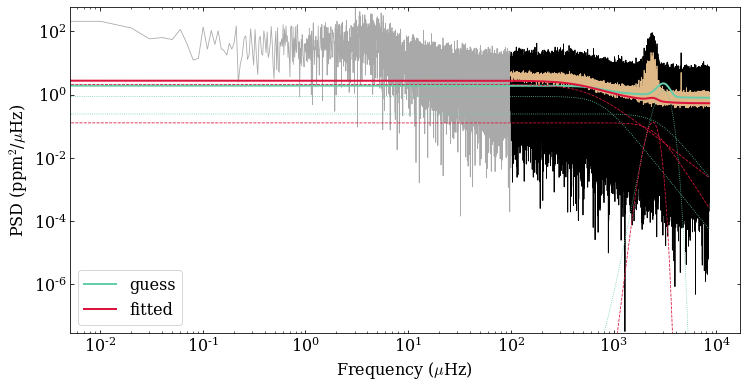

In [3]:
fitted_back, param_mle = perform_mle_background (freq, psd, n_harvey=2, fit_log=False, low_cut=100,
                                                 quickfit=True, power_law=False, spectro=False)

If you need uncertainties over the fitted parameter, you can then refine this analysis with a bayesian approach: 

Beginning fit


  0%|          | 0/1000 [00:00<?, ?it/s]/opt/miniconda3/envs/main-3.8/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:58<00:00, 17.01it/s]


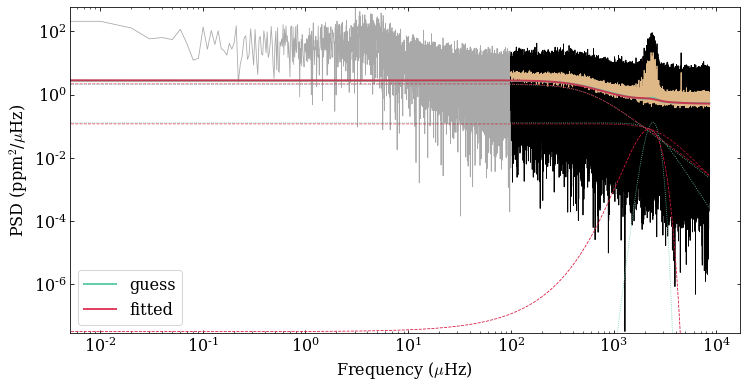

In [4]:
fitted_back, param_mcmc, sigma = explore_distribution_background (freq, psd, n_harvey=2, guess=param_mle, 
                                                                  fit_log=False, low_cut=100, nsteps=1000,
                                                                  nwalkers=64, discard=200, parallelise=True,
                                                                  quickfit=True, progress=True, power_law=False,
                                                                  spectro=False)

This step is by far longer than the previous one. Be particularly careful with what you want when setting ``nsteps`` and ``discard`` arguments.

## Individual mode parameters determination

With the determination of the background done, we are ready to begin the determination of the individual mode parameters. For this purpose, you need to create a *a2z* file that will be read by the ``peakbagging`` function. The file ``input_golf.a2z`` is given as an example of the most complex pattern you are able to fit. It contains guess for solar p-mode from *n*=8 to 27 and *l*=0 to 3.

In [5]:
df = read_a2z ('input_golf.a2z')
print (df.iloc[247:266].to_string ()) #show just a part of the df

      0  1       2     3            4    5    6             7            8
313  23  2   split  mode     0.400000  0.0  0.0  1.000000e-01     0.800000
311  23  2   width  mode     2.242577  0.0  0.0  1.000000e-08     8.000000
309  23  2    freq  mode  3430.868400  0.0  0.0  3.428868e+03  3432.868400
331  24  2    asym  mode    -0.014523  0.0  0.0 -2.000000e-01     0.200000
329  24  2  height  mode     0.003577  0.0  0.0  1.000000e-08     0.017887
332  24  2   split  mode     0.400000  0.0  0.0  1.000000e-01     0.800000
330  24  2   width  mode     3.222189  0.0  0.0  1.000000e-08     8.000000
328  24  2    freq  mode  3567.029200  0.0  0.0  3.565029e+03  3569.029200
350  25  2    asym  mode    -0.014482  0.0  0.0 -2.000000e-01     0.200000
348  25  2  height  mode     0.001987  0.0  0.0  1.000000e-08     0.009934
351  25  2   split  mode     0.400000  0.0  0.0  1.000000e-01     0.800000
349  25  2   width  mode     4.598504  0.0  0.0  1.000000e-08     8.000000
347  25  2    freq  mode 

Here, each parameters is individual for a given degree. It is also possible to share a parameter between element of same order *n* and distinct degrees *l* (note that when I say *same order* I designate pairs (n,0)/(n-1,2) and (n,1)/(n-1,3)). 

Here is an example of *a2z* input for the star we are concerned with in this tutorial:

In [6]:
a2z_file = 'input_saxo.a2z'
df = read_a2z (a2z_file)
print (df.to_string ()) 

     0  1       2       3            4    5    6            7            8
2   19  0    freq    mode  2256.762699  0.0  0.0  2249.605088  2263.920310
7   20  0    freq    mode  2366.928778  0.0  0.0  2359.771167  2374.086388
12  21  0    freq    mode  2477.267291  0.0  0.0  2470.109681  2484.424902
17  22  0    freq    mode  2587.778241  0.0  0.0  2580.620630  2594.935851
22  23  0    freq    mode  2698.461625  0.0  0.0  2691.304014  2705.619236
29   a  0   amp_l  global     1.000000  0.0  0.0     0.000000     0.000000
0   19  1    freq    mode  2198.735167  0.0  0.0  2191.577557  2205.892778
5   20  1    freq    mode  2308.901246  0.0  0.0  2301.743635  2316.058857
10  21  1    freq    mode  2419.239760  0.0  0.0  2412.082149  2426.397370
15  22  1    freq    mode  2529.750709  0.0  0.0  2522.593098  2536.908319
20  23  1    freq    mode  2640.434093  0.0  0.0  2633.276482  2647.591704
27   a  1   amp_l  global     1.500000  0.0  0.0     0.000000     0.000000
1   18  2    freq    mode

We are going to fit only one order:

Orders to fit: 21
Fitting on order 21
Window width: 96.7 muHz


100%|██████████| 1000/1000 [02:31<00:00,  6.60it/s]


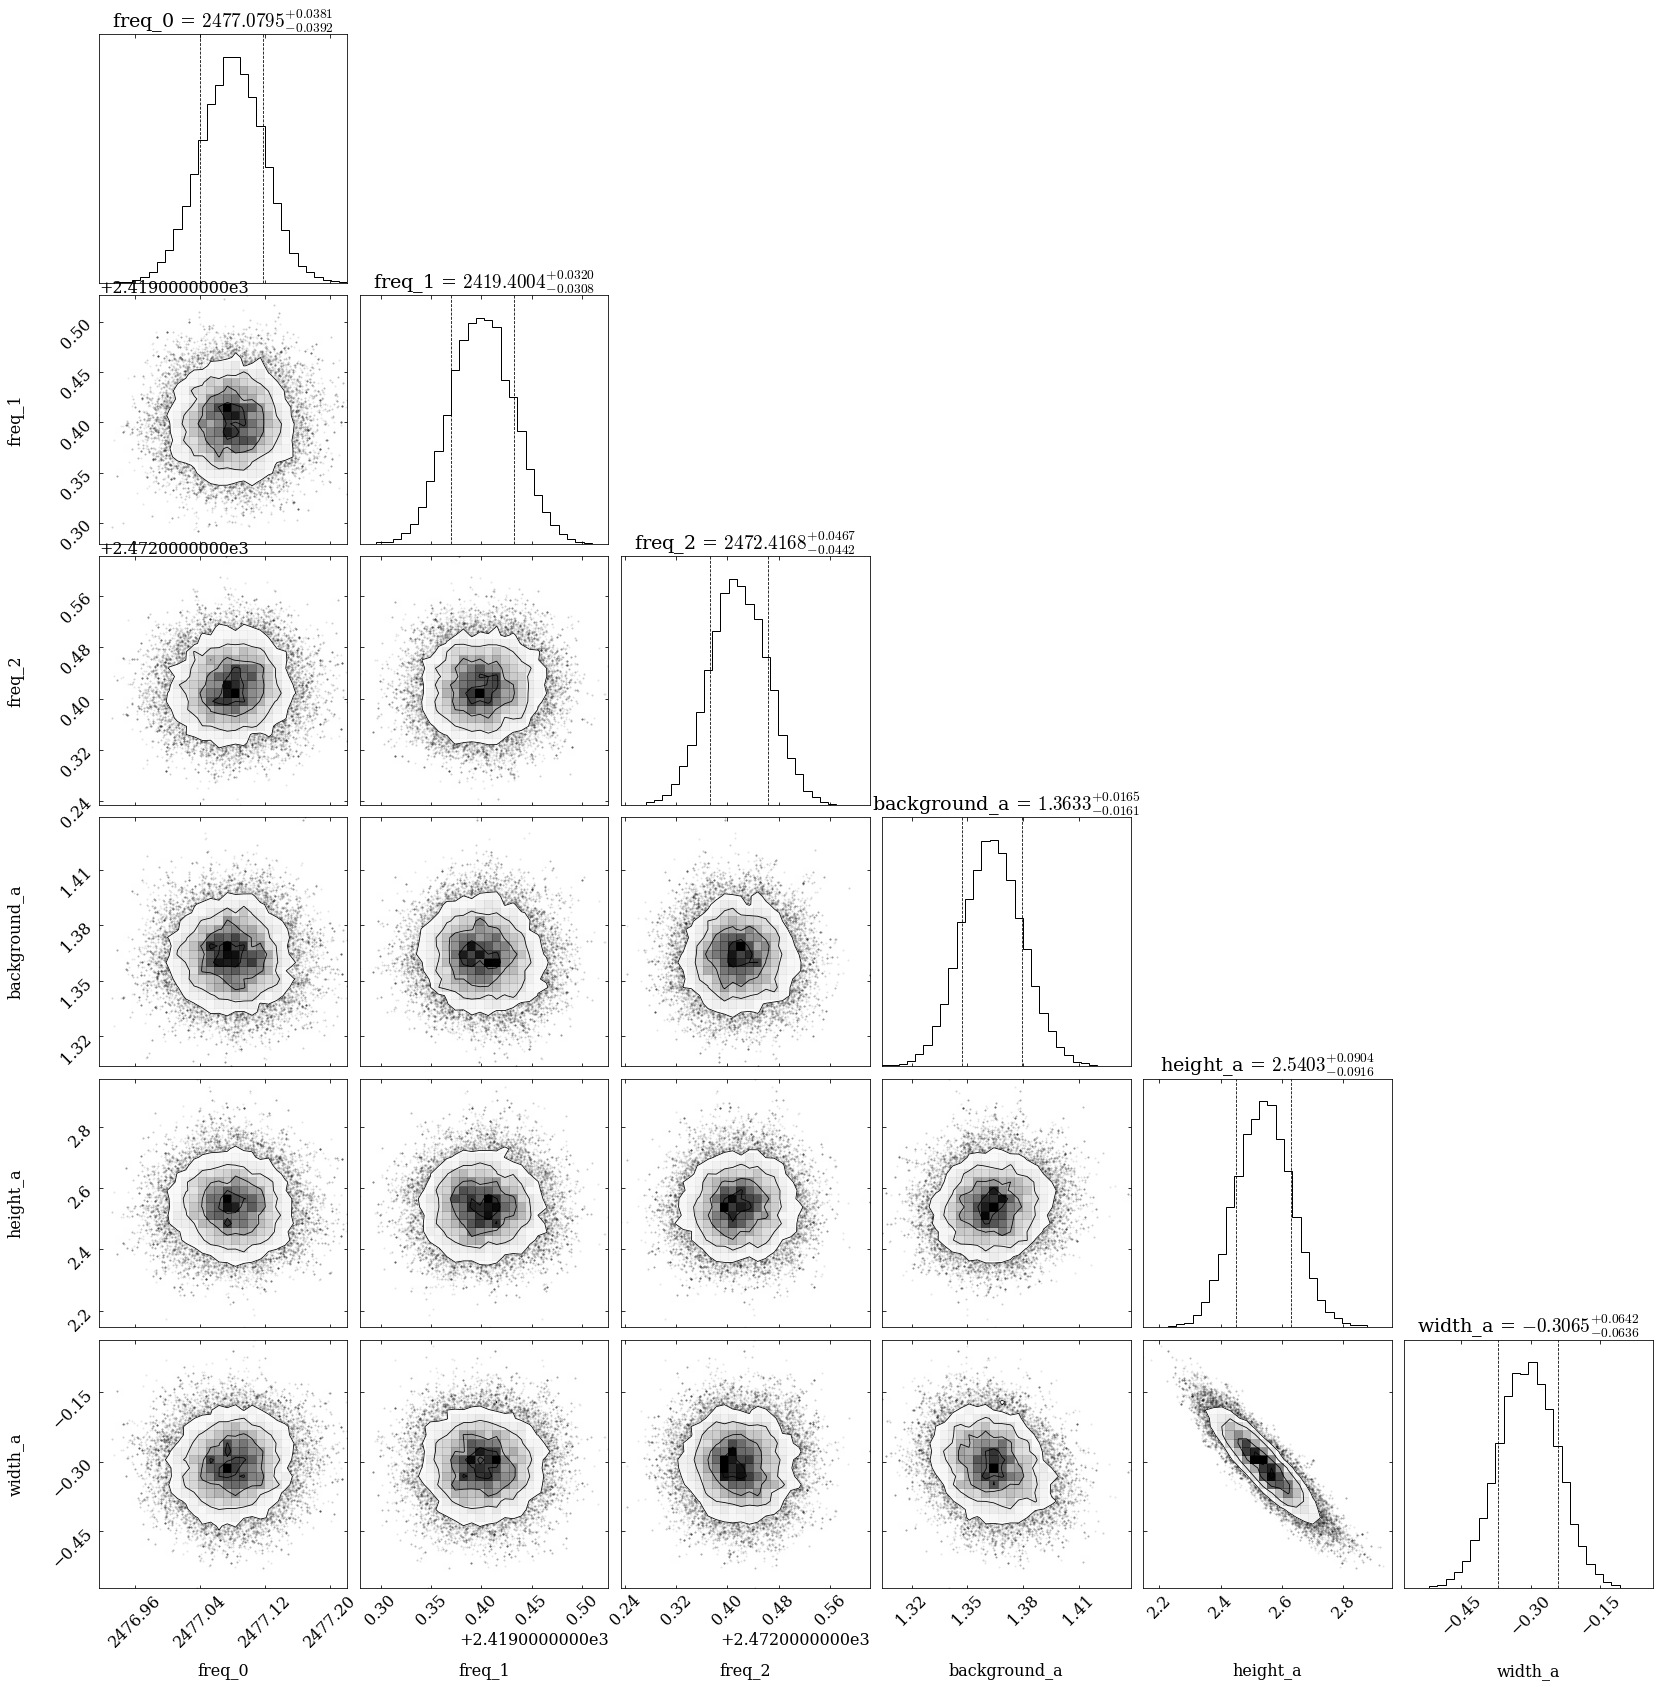

Ensemble sampling achieved


In [7]:
order_to_fit = [21]
df_a2z_fitted = peakbagging (a2z_file, freq, psd, back=fitted_back, spectro=False, nsteps_mcmc=1000, 
                             progress=True, strategy='order', discard=200, order_to_fit=order_to_fit,
                             show_corner=True, bins=30, parallelise=True)